# Analisis de tiempos de Cola

En la versión anterior analizamos las colas por camion v/s la actividad, ahora realizaremos una análisis similar pero considerando lo último obtenido de la reestructuración de los datos, es decir cuando logramos obtener un Dataset con los tiempos parcelados. 
Lo que se realizará será lo siguiente:

1. Nueva comparativa entre Act y las nuevas colas. Para ello debemos modificar la función para que pueda tomar filtros de destinos
2. Analizar las Colas por Mes y Año, para ello debemos arreglar el problema de los peaks.

In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import datetime
import seaborn as sns
from manager_propio import *

In [90]:
cols = ['Total Time','Datei','Datef','Ti','Tf']

#Cargamos el dataset de actividades
actividad = pd.read_csv('actividad.csv')
actividad = actividad.drop('Unnamed: 0',axis=1)
actividad = actividad.drop(cols,axis=1)
actividad['Start Act'] = pd.to_datetime(actividad['Start Act'], utc = True).dt.tz_convert('Chile/Continental')
actividad['End Act'] = pd.to_datetime(actividad['End Act'], utc = True).dt.tz_convert('Chile/Continental')
actividad['date start'] = pd.to_datetime(actividad['Start Act']).dt.date
actividad['date end'] = pd.to_datetime(actividad['End Act']).dt.date
actividad['time start'] = pd.to_datetime(actividad['Start Act']).dt.time
actividad['time end'] = pd.to_datetime(actividad['End Act']).dt.time
actividad['Day of year [In]'] = pd.to_datetime(actividad['Start Act']).dt.dayofyear
actividad['Day of year [Out]'] = pd.to_datetime(actividad['End Act']).dt.dayofyear
actividad['time Act'] = ((actividad['End Act']) - pd.to_datetime(actividad['Start Act']))/np.timedelta64(1, 's')

#cargamos el dataset de las colas antiguas
colas_old = pd.read_csv('colas.csv')
colas_old = colas_old.drop('Unnamed: 0',axis=1)
colas_old['Start Cola'] = pd.to_datetime(colas_old['Start Cola'], utc = True).dt.tz_convert('Chile/Continental')
colas_old['End Cola'] = pd.to_datetime(colas_old['End Cola'], utc = True).dt.tz_convert('Chile/Continental')
colas_old['date start'] = pd.to_datetime(colas_old['Start Cola']).dt.date
colas_old['date end'] = pd.to_datetime(colas_old['End Cola']).dt.date
colas_old['time start'] = pd.to_datetime(colas_old['Start Cola']).dt.time
colas_old['time end'] = pd.to_datetime(colas_old['End Cola']).dt.time
colas_old['Day of year [In]'] = pd.to_datetime(colas_old['Start Cola']).dt.dayofyear
colas_old['Day of year [Out]'] = pd.to_datetime(colas_old['End Cola']).dt.dayofyear
colas_old['time cola'] = ((colas_old['End Cola']) - pd.to_datetime(colas_old['Start Cola']))/np.timedelta64(1, 's')
#Cargamos el dataset de las nuevas colas.

colas = pd.read_csv("colas_filtradas_v2.csv")  #ya tiene las horas cambiadas
colas = colas.drop('Unnamed: 0',axis=1)


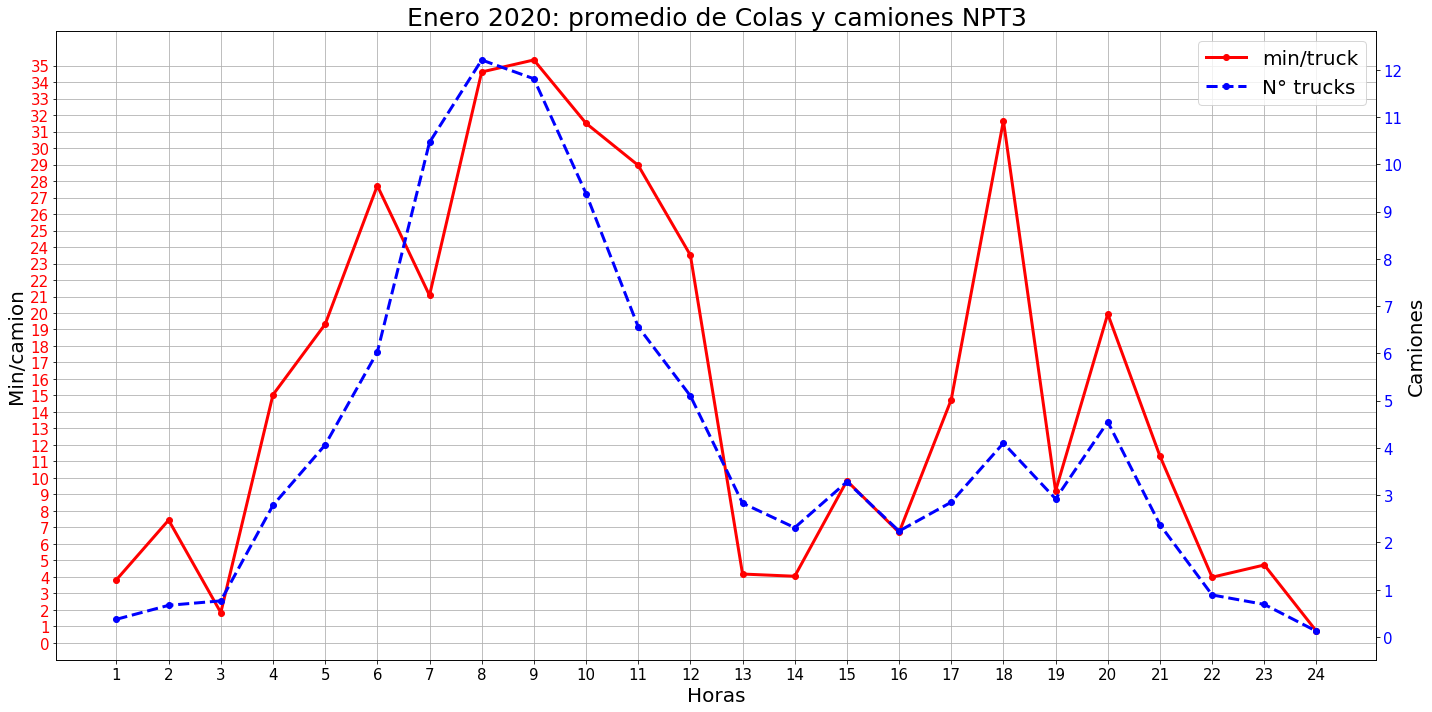

In [7]:
enero_2020 = stack_by_day(colas,'C NPT3',1,31,metric='mean')
plot_colas(enero_2020,'NPT3',"Enero 2020: promedio de Colas y camiones NPT3",file=None)

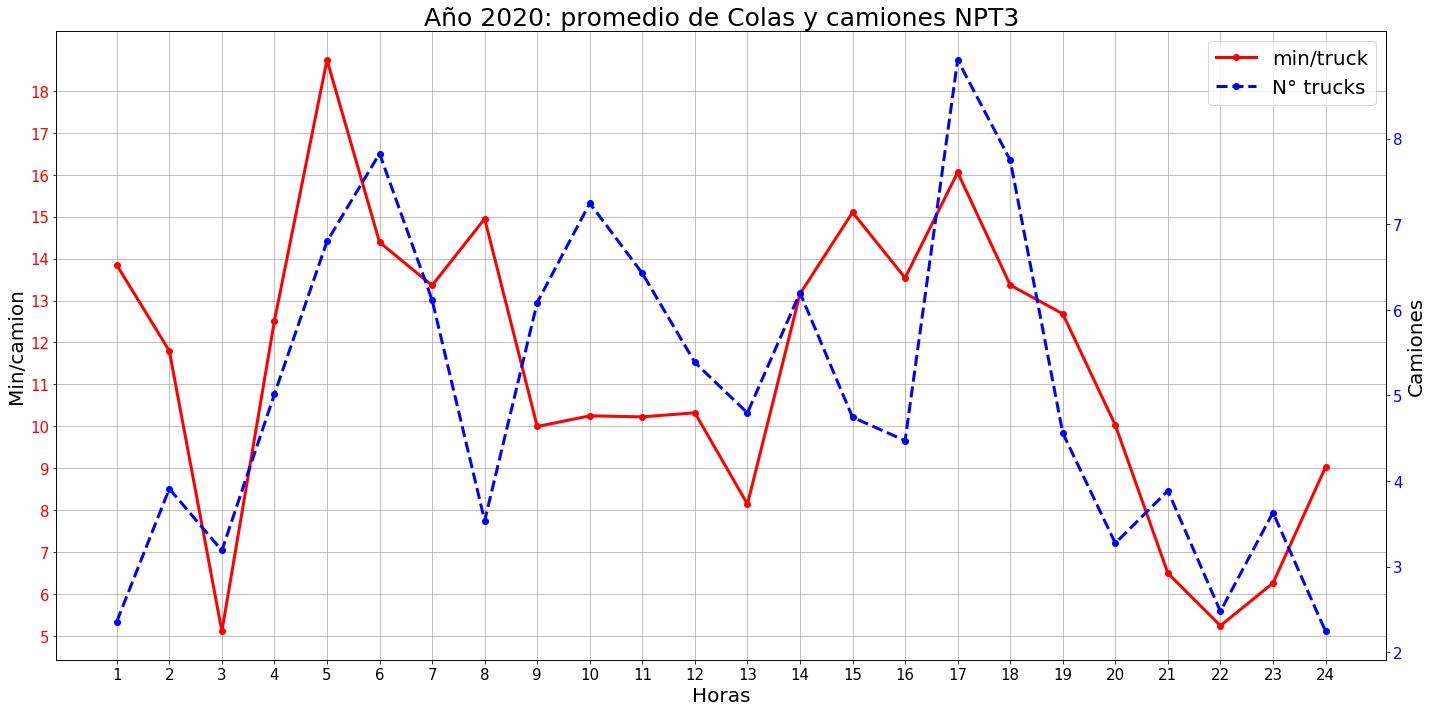

In [10]:
año_2020 = stack_by_day(colas,'C NPT3',1,160,metric='mean')
plot_colas(año_2020,'NPT3',"Año 2020: promedio de Colas y camiones NPT3",file=None)

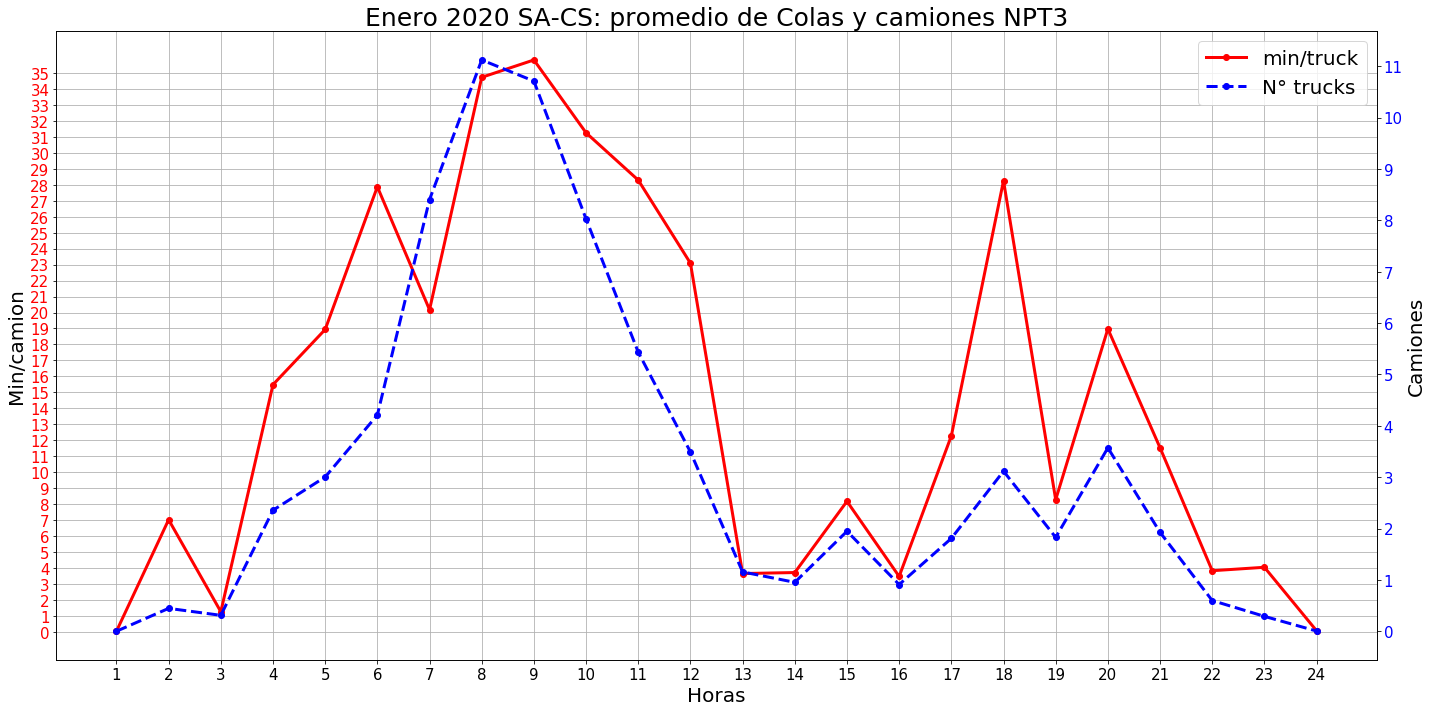

In [25]:
aux = colas[colas['Origin'] == 'Salar de Atacama']
enero_2020_NV = stack_by_day(aux,'C NPT3',1,31,metric='mean')
plot_colas(enero_2020_NV,'NPT3',"Enero 2020 SA-CS: promedio de Colas y camiones NPT3",file='Colas_SA-CS_enero_2020')

# 1. Analisis de Actividad vs Nuevas Colas (parceladas)

Recordemos como fue el __Primer análisis sin parcelar las colas__
![](./ACT_COLA/Analisis_enero_colas_actividad_peaks_NPT3_SA.png)

In [106]:
salar_1_act = analisis_por_dia(actividad,1,1,1,25,None,condicion='end',metric='max')
salar_enero_act = analisis_por_dia(actividad,1,31,1,25,None,condicion='end',metric='mean')
salar_enero_cola = stack_by_day(aux,'C NPT3',1,31,metric='mean')

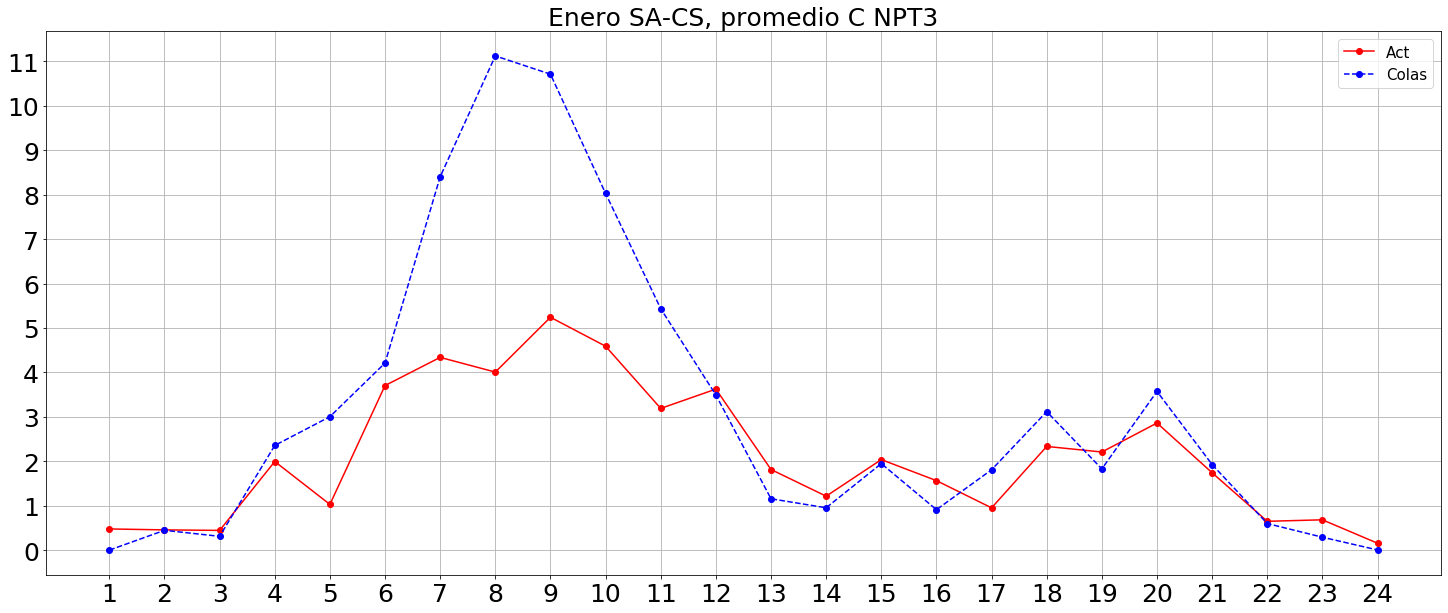

In [111]:
plt.figure(figsize=(25,10))
plt.plot(salar_enero_cola['block'],salar_enero_act['C NPT3'],'ro-',label="Act")
plt.plot(salar_enero_cola['block'],salar_enero_cola['camiones'],'bo--',label="Colas")
plt.grid(True)
plt.legend(fontsize=15)
plt.xticks(np.arange(1,25,1),fontsize=25)
plt.yticks(np.arange(0,12,1),fontsize=25)
plt.title("Enero SA-CS, promedio C NPT3",fontsize=25)
plt.savefig("enero_sa-cs_prom_npt3.png")
plt.show()

# Procedemos a arreglar el tema de los Peaks

In [144]:
def convert_df_to_df_2(df,zone='C NPT3',day=1):
    a = df[(df['Day of year [In]'] == day) &  (df['ZO'] == zone)] #filtramos por día y zona
    a = a.iloc[:,14:]   #nos quedamos solamente con las columnas de bloques horarios
    suma_time = a.sum().tolist()  #creamos la lista de la suma de los tiempos en cada bloque horario
    cuenta_trucks = a[a>0].count().tolist() #creamos la lista que suma los camiones que habian en ese bloque horario
    min_camion=[] #iniciamos la lista final [[x1,y1,z1],[x2,y2,z2]] donde x es el bloque, y es la suma min/camion, z es el N° de camiones
    for i in range(24):
        if (cuenta_trucks[i] == 0 or suma_time[i] == 0 ):  #no dividimos por cero
            min_camion.append([i+1,0,0])
        else:
            b = suma_time[i]/float(cuenta_trucks[i])
            min_camion.append([i+1,int(b),cuenta_trucks[i]])
    data = pd.DataFrame(min_camion,columns=["block","minutos/camion","camiones"]).set_index(np.arange(1,25,1))
    return data, min_camion

def stack_by_day_2(df,zone,dia_inicial,dia_final,metric='max',name=None,origen=None):
    "Nos entrega el análisis por una cantidad X de dias, toma los días del año"
    count = 0
    df_final = None
    if (origen != None):
        df = df[df['Origin'] == origen]
    super_list = []
    contador = 0
    for i in range(dia_inicial,dia_final+1):
        #print(i)
        aux, lista = convert_df_to_df_2(df,zone,i)
        if count == 0:
            df_final = aux
            count += 1
        else:
            if (metric == 'max'):
                df_final = pd.concat([df_final, aux]).max(level=0)   #Aquí indico que necesito los peaks
            elif (metric == 'mean'):
                df_final = pd.concat([df_final,aux]).mean(level=0)
        super_list.append(lista)
        if contador > 1:
            del super_list[0]
        contador+=1
    if name != None:
        df_final.sort_index(axis=0).to_csv(name,index=False)
    return df_final.sort_index(axis=0) , super_list

In [149]:
test_a, lista_2 = stack_by_day_2(aux,'C NPT3',1,3,metric='peaks')

In [152]:
print(len(lista_1))
for i in lista_1:
    print(i)

2
[[1, 0, 0], [2, 0, 0], [3, 0, 0], [4, 0, 0], [5, 5, 1], [6, 42, 1], [7, 0, 0], [8, 17, 1], [9, 0, 0], [10, 12, 1], [11, 0, 0], [12, 0, 0], [13, 0, 0], [14, 0, 0], [15, 0, 0], [16, 0, 0], [17, 18, 5], [18, 45, 8], [19, 32, 9], [20, 30, 7], [21, 16, 3], [22, 0, 0], [23, 0, 0], [24, 0, 0]]
[[1, 0, 0], [2, 0, 0], [3, 17, 5], [4, 34, 4], [5, 0, 0], [6, 2, 1], [7, 24, 4], [8, 8, 1], [9, 17, 1], [10, 0, 0], [11, 28, 3], [12, 30, 5], [13, 31, 7], [14, 37, 5], [15, 35, 8], [16, 24, 6], [17, 1, 1], [18, 21, 5], [19, 17, 2], [20, 0, 0], [21, 0, 0], [22, 0, 0], [23, 0, 0], [24, 0, 0]]


In [153]:
print(len(lista_2))
for i in lista_2:
    print(i)

2
[[1, 0, 0], [2, 0, 0], [3, 17, 5], [4, 34, 4], [5, 0, 0], [6, 2, 1], [7, 24, 4], [8, 8, 1], [9, 17, 1], [10, 0, 0], [11, 28, 3], [12, 30, 5], [13, 31, 7], [14, 37, 5], [15, 35, 8], [16, 24, 6], [17, 1, 1], [18, 21, 5], [19, 17, 2], [20, 0, 0], [21, 0, 0], [22, 0, 0], [23, 0, 0], [24, 0, 0]]
[[1, 0, 0], [2, 0, 0], [3, 0, 0], [4, 0, 0], [5, 0, 0], [6, 24, 2], [7, 6, 1], [8, 0, 0], [9, 0, 0], [10, 0, 0], [11, 0, 0], [12, 0, 0], [13, 0, 0], [14, 0, 0], [15, 0, 0], [16, 0, 0], [17, 4, 1], [18, 25, 3], [19, 18, 1], [20, 0, 0], [21, 19, 1], [22, 0, 0], [23, 0, 0], [24, 0, 0]]


__Lo dejamos en standby para obtener los resultados para el entregable 2__